In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from sympy import S, symbols, printing

from compilers import * 
from utils import *
from imaginarycompilers import *

import json

In [2]:
X = np.array([[0, 1],
     [1, 0]])
Z = np.array([[1, 0],
     [0, -1]])
Y = np.array([[0, -1j],
     [1j, 0]])
I = np.array([[1, 0],
     [0, 1]])
XX = np.kron(X, X) #tensor products between two Pauli's
XZ = np.kron(X, Z)
ZZ = np.kron(Z, Z)
ZX = np.kron(Z, X)
II = np.kron(I, I)
IX = np.kron(I, X)
XI = np.kron(X, I)
IZ = np.kron(I, Z)
ZI = np.kron(Z, I)
#List of Hamiltonian decomposition terms H_j for H = \sum_j h_j H_j
Hlist = np.array([XX, XZ, ZX, ZZ, IX, IZ, XI, ZI])
hj = [1.0, 2.0, -3.0, -4.0, -2.0, 1.0, 0.5, 0.25] #list of normalized coefficients

print(Hlist.shape)

hamiltonian_list = []
for i in range(len(hj)):
    hamiltonian_list.append(hj[i] * Hlist[i, :, :])
hamiltonian_list = np.array(hamiltonian_list)
pauli_hamiltonian = hamiltonian_list
print(hamiltonian_list.shape)
#print(hamiltonian_list)

(8, 4, 4)
(8, 4, 4)


In [3]:
# A simple function that computes the graph distance between two sites
from ast import operator


def dist(site1, site2):
    distance_vec = site1 - site2
    distance = np.abs(distance_vec[0]) + np.abs(distance_vec[1])
    return distance

# A simple function that initializes a graph in the form of an np.array of coordinates 
def initialize_graph(x_sites, y_sites):
    coord_list = []
    for i in range(x_sites):
        for j in range(y_sites):
            coord_list.append([i,j])
    return np.array(coord_list)

#A funciton that initializes a Pauli operator in the correct space, acting on a specific qubit
def initialize_operator(operator_2d, acting_space, space_dimension):
    if acting_space>space_dimension:
        return 'error'
    for i in range(acting_space):
        operator_2d = np.kron(operator_2d, I)
    for j in range(space_dimension - acting_space-1):
        operator_2d = np.kron(I, operator_2d)
    return operator_2d

def initialize_observable(operator_2d, space_dimension):
    temp_op = np.copy(operator_2d)
    for i in range(space_dimension - 1):
        temp_op = np.kron(temp_op, operator_2d)
    return temp_op 

def exp_loc_graph_hamiltonian(x_dim, y_dim, rng_seed):
    np.random.seed(rng_seed)
    hamiltonian_list = []
    graph = initialize_graph(x_dim, y_dim)
    for i in range(x_dim*y_dim):
        for j in range(y_dim*x_dim):
            if i != j: #long range interaction
                alpha = np.random.normal()
                hamiltonian_list.append(alpha * 
                    np.matmul(initialize_operator(Z, i, x_dim*y_dim), initialize_operator(Z, j, x_dim*y_dim)) *
                        10.0**(-dist(graph[i], graph[j]))) 

            # if (dist(graph[i], graph[j])==1) and (i>j): #nearest neighbour interaction
            #     beta = np.random.normal()
            #     hamiltonian_list.append(beta * np.matmul(initialize_operator(Y, i, x_dim*y_dim), initialize_operator(Y, j, x_dim*y_dim)))
            
        gamma = np.random.normal()
        hamiltonian_list.append(4* gamma * initialize_operator(X, i, x_dim*y_dim))
                
    return np.array(hamiltonian_list)

#a function that generates the list of hamiltonian terms for a random NN Heinsenberg model with abritrary b_field strength
# different from the other funciton as this one just returns a hamiltonian (no tracking of indices like in the other .ipynb)

def heisenberg_hamiltonian(length, b_field, rng_seed, b_rand):
    #b_rand is a boolean that either sets the field to be randomized or the interactions (if false)
    y_dim = 1
    x_dim = length #restrict to 1d spin change so we can get more disjoint regions
    np.random.seed(rng_seed)
    hamiltonian_list = []
    indices = []
    #graph = initialize_graph(x_dim, y_dim)
    operator_set = [X, Y, Z]
    lat_points = x_dim*y_dim
    for k in operator_set:
        for i in range(lat_points):
            for j in range (lat_points):
                if (i == j+1):
                    if b_rand == True:
                        hamiltonian_list.append(1 * np.matmul(initialize_operator(k, i, lat_points), initialize_operator(k, j, lat_points)))
                        #indices.append([i, j])
                    else:
                        alpha = np.random.exponential(scale=0.1)
                        hamiltonian_list.append(alpha * np.matmul(initialize_operator(k, i, lat_points), initialize_operator(k, j, lat_points)))
                        #indices.append([i, j])

            if np.array_equal(Z, k) == True:
                if b_rand == True:
                    beta = np.random.exponential() #if we want to randomize the field strength reponse at each site (might be unphysical)
                    hamiltonian_list.append(beta * initialize_operator(k, i, lat_points))
                    #indices.append([i])
                else: 
                    hamiltonian_list.append(b_field * initialize_operator(k, i, lat_points))
                    #indices.append([i])

    return np.array(hamiltonian_list)

In [4]:
def ising_model(dim, b_field = 0, rng_seed=1):
    '''Function does not currently have randomization effects, b_field picks the J/g ratio, where J==1'''
    ham_list = []
    for i in range(dim):
        for j in range(dim):
            if ((i==j+1) or (i==0 and j == dim-1)):
                ham_list.append(-1* np.matmul(initialize_operator(Z, i, dim), initialize_operator(Z, j, dim)))
            
        
        if b_field != 0:
            ham_list.append(b_field * initialize_operator(X, j, dim))

    return np.array(ham_list)

In [5]:
poli = normalize_hamiltonian(pauli_hamiltonian)
print(poli.shape)

sim = CompositeSim(poli, nb=1, inner_order=1, state_rand=False, exact_qd=True, use_density_matrices=True, imag_time=True)
partition_sim(sim, "qdrift")


tstart = 0.0005
tfinal = 2
tsteps = 20
times = np.geomspace(tstart, tfinal, tsteps)

#print(multi_infidelity_sample(sim, 1, exact_time_evolution_density(sim.unparsed_hamiltonian, 1, sim.initial_state), 40, 20))
epsilon_data=[]
for t in times:
    #density matrices
    epsilon_data.append(sim_trace_distance(sim, time=t, iterations=1, nb=1))
    #epsilon_data.append(infidelity(sim.simulate(t, iterations=15), exact_imaginary_channel(poli, t, sim.initial_state)))

    #imaginary time class
    #epsilon_data.append(i_sim.trace_dist(t, samples=1))

    #for vectors
    #exact_state = linalg.expm(-1 * sum(poli) * t) @ sim.initial_state
    #epsilon_data.append(infidelity(sim.simulate(t, iterations=1), exact_state / np.linalg.norm(exact_state, ord=2)))
#print(epsilon_data)
print('the trace is:')
print(np.trace(sim.final_state))


(8, 4, 4)
the trace is:
1.0


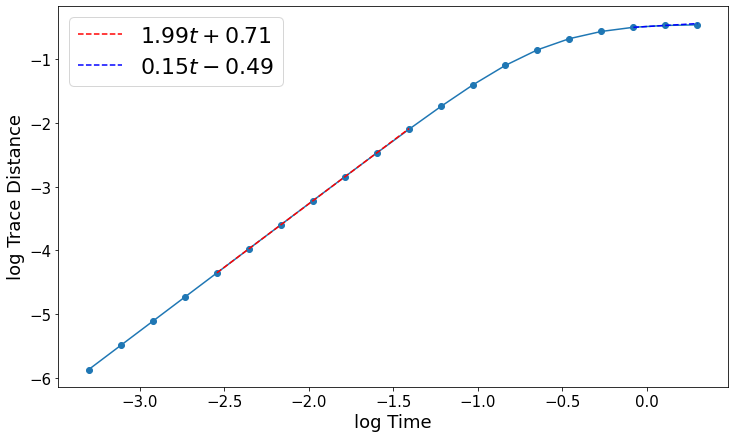

In [6]:
data = np.log10(epsilon_data)
log_times = np.log10(times)
plt.figure(figsize = (12, 7))
plt.plot(log_times, data, 'o-') 
plt.xlabel('log Time', size = 18)
plt.ylabel('log Trace Distance', size = 18)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)

start_fit_points= 4 #declare the starting point to fit in the data
end_fit_points = 10

p = np.polyfit(log_times[start_fit_points: end_fit_points], data[start_fit_points: end_fit_points], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[start_fit_points], log_times[end_fit_points], 50)
y_new = f(t_new)

data = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)
plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize= 22)

data = np.log10(epsilon_data)
start_fit_points1= -3 #declare the starting point to fit in the data
end_fit_points1 = -1
p1 = np.polyfit(log_times[start_fit_points1: end_fit_points1], data[start_fit_points1: end_fit_points1], 1)
f1 = np.poly1d(p1)

t_new1 = np.linspace(log_times[start_fit_points1], log_times[end_fit_points1], 50)
y_new1 = f1(t_new1)

data = symbols("t")
poly1 = sum(S("{:6.2f}".format(v))*data**i for i, v in enumerate(p1[::-1]))
eq_latex1 = printing.latex(poly1)

plt.plot(t_new1, y_new1, 'b--', label="${}$".format(eq_latex1))
plt.legend(fontsize= 22)
plt.show()

### Cost Analysis

In [19]:
heisenberg = heisenberg_hamiltonian(length = 7, b_field = 5, rng_seed=1, b_rand=False)
print(heisenberg.shape)
normed_ham = normalize_hamiltonian(heisenberg)

trotter = CompositeSim(normed_ham, inner_order=1, state_rand=True, use_density_matrices=True, exact_qd=True, imag_time=True) 
qdrift = CompositeSim(normed_ham, inner_order=1, state_rand=True, use_density_matrices=True, exact_qd=True, imag_time=True) 
chop = CompositeSim(normed_ham, inner_order=1, state_rand=True, use_density_matrices=True, exact_qd=True, imag_time=True) 

partition_sim(trotter, 'trotter')
partition_sim(qdrift, "qdrift")
partition_sim(chop, "chop", chop_threshold = 0.75)
print(chop.trotter_norms, chop.qdrift_norms)
print(len(chop.trotter_norms), len(chop.qdrift_norms))

t_i = 0.005
t_f= 3.14
t_steps = 15
time = np.geomspace(t_i, t_f, t_steps)
epsilon=0.001

print(time)


(25, 128, 128)
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [0.01079211674518371, 0.025482505060266083, 2.2876271728617186e-06, 0.00720025509707838, 0.003174191903893478, 0.0019376774330746695, 0.00412229268164161, 0.008479529636141498, 0.010109050834214971, 0.015479195497215147, 0.010866787412364902, 0.02311759419418845, 0.004574488150536607, 0.04209394582415611, 0.0005553924953684671, 0.022201606529932652, 0.010801820928888588, 0.016360146278060757]
7 18
[0.005      0.00792181 0.01255101 0.01988533 0.03150555 0.04991618
 0.07908526 0.12529964 0.19851992 0.3145273  0.49832492 0.78952678
 1.25089578 1.98187102 3.14      ]


In [20]:
#CompSim_results = dict()
qdrift_results = dict()
trotter_results = dict()
chop_results = dict()

#local_partition(local_trot, "trotter")
trot_terms = dict()
qd_terms = dict()
nb_vals = dict()

for t in time:
    # partition_sim(sim, "exact_optimal_chop", time =t, epsilon=epsilon)
    # CompSim_results[t] = int(sim.gate_count)
    # trot_terms[t] = len(sim.trotter_norms)
    # qd_terms[t] = len(sim.qdrift_norms)
    # nb_vals[t] = sim.nb

    trotter_results[t] = int(exact_cost(trotter, time=t, nb=1, epsilon=epsilon))

    chop_results[t] = int(exact_cost(chop, time=t, nb=4, epsilon=epsilon))

#qd_times = time[:16]
#for t in qd_times:
    #qdrift_results[t] = int(exact_cost(qdrift, time=t, nb=1, epsilon=epsilon))

[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below error threshold
[sim_channel_performance] Iterations too large, already below er

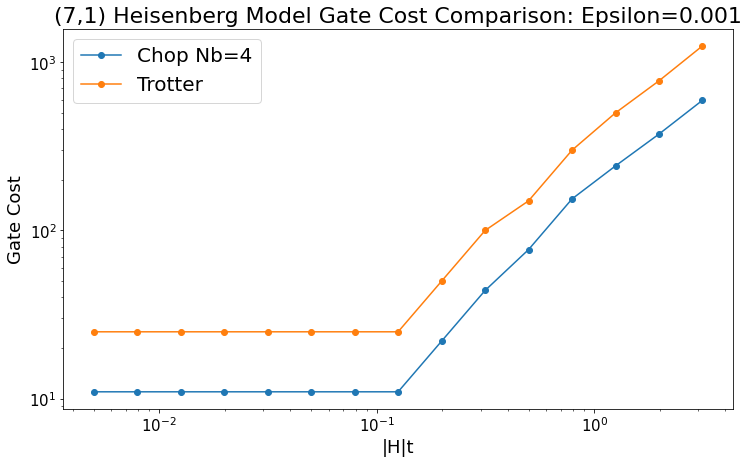

In [21]:
#plotting
plt.figure(figsize = (12, 7))
plt.title("(7,1) Heisenberg Model Gate Cost Comparison: Epsilon=0.001", size =22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("|H|t", size =18)
plt.ylabel("Gate Cost", size =18)
plt.loglog(time, list(chop_results.values()), "o-", label="Chop Nb=4")
#plt.loglog(time, list(local_trot_results.values()), "o-", label="Local Trotter")
plt.loglog(time, list(trotter_results.values()), "o-",label="Trotter")
#plt.loglog(qd_times[:13], list(qdrift_results.values()),"o-", label="QDrift")
plt.legend(fontsize = 20)
plt.show()

In [22]:
print(list(chop_results.values()))
print(np.trace(trotter.final_state))

[11, 11, 11, 11, 11, 11, 11, 11, 22, 44, 77, 154, 242, 374, 594]
(1.0000000000000002+0j)


In [11]:
emplist = []
for i in range(0, 20):
    emplist.append(i)
print(emplist[-4:])

[16, 17, 18, 19]


### Dynamics

In [22]:
dim = 6
ising = normalize_hamiltonian(ising_model(dim=dim, b_field=0.1))
cooler = CompositeSim(ising, inner_order=1, nb=100, state_rand=True, use_density_matrices=True, exact_qd=True, imag_time=True, rng_seed=1) 
partition_sim(cooler, "qdrift")
print(cooler.initial_state)
 
beta = np.linspace(0.00001, 1, 100)
populations = []
energies = []
spins = []
amplitudes = np.zeros((2**dim, len(beta)))

for b in range(len(beta)):
    state_t = cooler.simulate(time=beta[b], iterations=1)
    if cooler.use_density_matrices == True:
        #populations.append(np.real(np.diag(state_t))
        energies.append(np.real(np.trace(sum(ising) @ state_t)))
        local_spin = []
        for j in range(dim):
            local_spin.append(np.real(np.trace(state_t @ initialize_operator(Z, j, dim))))
        spins.append(local_spin)
    else:
        energies.append(np.real((state_t.T.conj() @ sum(ising) @ state_t).flat[0]))
        amplitudes[:, b] =  np.real(np.abs(state_t.flat[0])**2)
amplitudes = np.transpose(amplitudes)

[[ 0.02692756+0.j         -0.00964571-0.00164814j -0.00285558-0.01961837j
  ...  0.02469851-0.01306447j  0.01523956-0.02239909j
  -0.00298631-0.00650151j]
 [-0.00964571+0.00164814j  0.00355606+0.j          0.00222366+0.00685271j
  ... -0.00804761+0.00619152j -0.00408799+0.00895632j
   0.00146766+0.00214612j]
 [-0.00285558+0.01961837j  0.00222366-0.00685271j  0.01459601+0.j
  ...  0.00689907+0.01937982j  0.014703  +0.0134783j
   0.00505344-0.00148625j]
 ...
 [ 0.02469851+0.01306447j -0.00804761-0.00619152j  0.00689907-0.01937982j
  ...  0.02899248+0.j          0.02484542-0.01315111j
   0.00041523-0.00741219j]
 [ 0.01523956+0.02239909j -0.00408799-0.00895632j  0.014703  -0.0134783j
  ...  0.02484542+0.01315111j  0.02725696+0.j
   0.00371804-0.00616361j]
 [-0.00298631+0.00650151j  0.00146766-0.00214612j  0.00505344+0.00148625j
  ...  0.00041523+0.00741219j  0.00371804+0.00616361j
   0.00190094+0.j        ]]


(array([-7., -6., -5., -4., -3., -2., -1.,  0.,  1.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

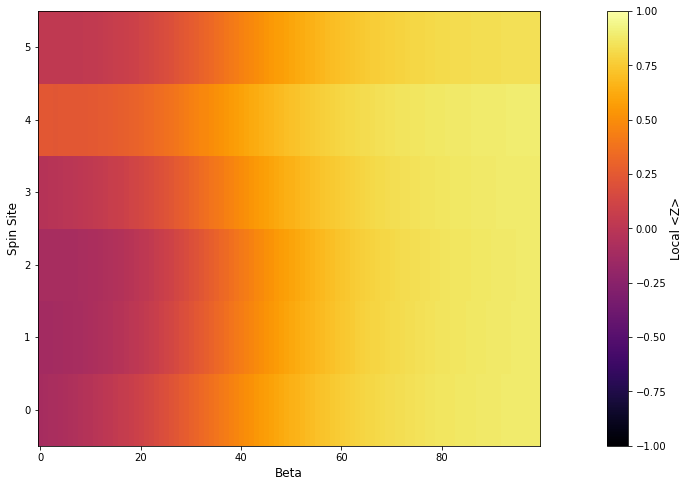

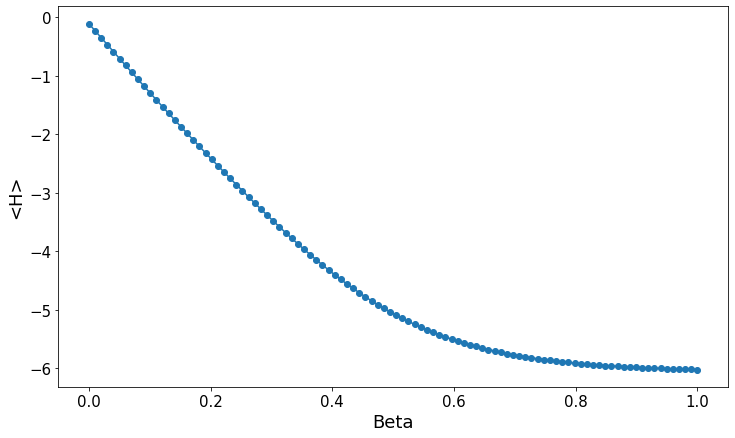

In [23]:
plt.figure(figsize = (12,8))
#plt.ylim(-60,60) #limits the range the plot shows
plt.xlabel('Beta', size = 12)
plt.ylabel('Spin Site', size = 12)
plt.imshow(np.transpose(spins), origin = 'lower', aspect = 'auto', 
           cmap = 'inferno', vmax=1, vmin=-1, interpolation = 'none') 
# vmax alters the sensitivity of the colour plot, so increase for large particle numbers
cbar = plt.colorbar(pad = 0.1) #pad chooses the distance of the colour bar from the plot
cbar.set_label('Local <Z>',size=12) 

plt.figure(figsize = (12, 7))
plt.plot(beta, energies, 'o-') 
plt.xlabel('Beta', size = 18)
plt.ylabel('<H>', size = 18)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)